# Stratified Sampling for Labeling Platform

This notebook samples responses from a benchmark run with stratified sampling for the human labeling platform.

## Features
- Filters models with <20 responses
- Randomly samples each prompt_id 1-2 times (evenly distributed)
- Evenly distributes models across selected prompts
- Generates seed file format compatible with labeling platform
- Visualizes sampling distribution
- Exports to JSONL (for DB push) and CSV (for inspection)


In [282]:
# Standard library imports
from __future__ import annotations
from pathlib import Path
import json
import sys
import warnings
import random
from collections import Counter, defaultdict

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
# Add project root to path to import RunRecord
# Notebook is in outputs/runs/, so go up 2 levels to project root
project_root = Path().resolve()
if project_root.name == 'runs':
    project_root = project_root.parent.parent
elif project_root.name == 'outputs':
    project_root = project_root.parent
sys.path.insert(0, str(project_root))
from src.benchmark.core.types import RunRecord

# Configure warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


## Configuration

Enter the run hash ID and target number of responses below.


In [283]:
# Configuration
RUN_HASH = "2fd32deccbc3905b"  # Change this to sample from a different run
TARGET_RESPONSES = 150  # Target number of responses to sample
MIN_MODEL_RESPONSES = 20  # Minimum responses required for a model to be included

# Define paths - try relative to current directory first, then project root
run_dir = Path(f"run_{RUN_HASH}")
if not run_dir.exists():
    # Try from project root
    run_dir = Path(f"outputs/runs/run_{RUN_HASH}").resolve()
    if not run_dir.exists():
        # Try absolute path from project root
        run_dir = project_root / "outputs" / "runs" / f"run_{RUN_HASH}"

run_jsonl = run_dir / "run.jsonl"
grid_jsonl = run_dir / "grid.jsonl"

# Validate paths exist
if not run_dir.exists():
    raise FileNotFoundError(f"Run directory not found: {run_dir}")
if not run_jsonl.exists():
    raise FileNotFoundError(f"Run data file not found: {run_jsonl}")
if not grid_jsonl.exists():
    raise FileNotFoundError(f"Grid data file not found: {grid_jsonl}")

## Data Loading


In [284]:
# Load Data
def load_run_data(path: Path) -> pd.DataFrame:
    """Load run data from JSONL file using RunRecord."""
    records = []
    for record in RunRecord.iter_jsonl(path):
        if record.is_success():
            payload = record.to_payload()
            records.append(payload)
    return pd.DataFrame(records)

def load_grid_data(path: Path) -> pd.DataFrame:
    """Load grid data from JSONL file."""
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(records)

# Load data
df_runs = load_run_data(run_jsonl)
df_grid = load_grid_data(grid_jsonl)

print(f"Loaded {len(df_runs)} run records")
print(f"Loaded {len(df_grid)} grid prompts")
print(f"\nRun data shape: {df_runs.shape}")
print(f"Grid data shape: {df_grid.shape}")
print(f"\nUnique models: {df_runs['model_id'].nunique()}")
print(f"Unique prompts: {df_runs['prompt_id'].nunique()}")


Loaded 1903 run records
Loaded 96 grid prompts

Run data shape: (1903, 18)
Grid data shape: (96, 3)

Unique models: 32
Unique prompts: 96


## Model Filtering

Filter out models with fewer than the minimum required responses.


In [285]:
# Count responses per model
model_counts = df_runs.groupby('model_id').size().reset_index(name='count')
model_counts = model_counts.sort_values('count', ascending=False)

print("Response counts by model:")
print(model_counts.to_string(index=False))

# Filter models with >= MIN_MODEL_RESPONSES
valid_models = model_counts[model_counts['count'] >= MIN_MODEL_RESPONSES]['model_id'].tolist()
excluded_models = model_counts[model_counts['count'] < MIN_MODEL_RESPONSES]['model_id'].tolist()

print(f"\nValid models (>= {MIN_MODEL_RESPONSES} responses): {len(valid_models)}")
print(f"Excluded models (< {MIN_MODEL_RESPONSES} responses): {len(excluded_models)}")

if excluded_models:
    print(f"\nExcluded models: {', '.join(excluded_models[:5])}")
    if len(excluded_models) > 5:
        print(f"... and {len(excluded_models) - 5} more")

# Filter run data to only include valid models
df_runs_filtered = df_runs[df_runs['model_id'].isin(valid_models)].copy()

print(f"\nFiltered run data: {len(df_runs_filtered)} records")
print(f"Removed {len(df_runs) - len(df_runs_filtered)} records from excluded models")


Response counts by model:
                                                model_id  count
                                  cerebras/llama-3.3-70b     96
                               groq/llama-3.1-8b-instant     96
                            mistral/mistral-small-latest     96
                           mistral/mistral-medium-latest     96
                            mistral/mistral-large-latest     96
                                     groq/qwen/qwen3-32b     96
                        groq/moonshotai/kimi-k2-instruct     96
                 cerebras/qwen-3-235b-a22b-instruct-2507     96
      groq/meta-llama/llama-4-maverick-17b-128e-instruct     96
                            groq/llama-3.3-70b-versatile     96
          groq/meta-llama/llama-4-scout-17b-16e-instruct     96
                            google/gemini-2.5-flash-lite     96
                                 google/gemini-2.5-flash     96
                            google/gemini-2.0-flash-lite     96
              

## Stratified Sampling

Sample prompts 1-2 times each, then evenly distribute models across selected prompts.


In [286]:
# Stratified Sampling Algorithm
# Ensures ALL prompts selected 1-2 times, models evenly distributed

all_prompt_ids = sorted(df_runs_filtered['prompt_id'].unique())
all_model_ids = sorted(df_runs_filtered['model_id'].unique())
num_prompts = len(all_prompt_ids)
num_models = len(all_model_ids)

print(f"Total unique prompts: {num_prompts}")
print(f"Total unique models: {num_models}")

# Build availability map: (prompt_id, model_id) -> list of records
available_combinations = defaultdict(list)
for _, row in df_runs_filtered.iterrows():
    key = (row['prompt_id'], row['model_id'])
    available_combinations[key].append(row)

print(f"Available (prompt, model) combinations: {len(available_combinations)}")

# Calculate target distribution
target_per_model = TARGET_RESPONSES / num_models
min_target = int(target_per_model)
max_target = min_target + 1

print(f"\nTarget distribution:")
print(f"  Per model: {target_per_model:.2f} (min: {min_target}, max: {max_target})")

# Initialize tracking
prompt_counts = Counter()
model_counts = Counter()
selected_combinations = set()  # Track (prompt_id, model_id) combinations to prevent duplicates
selected_records = []

def score_candidate(prompt_id, model_id, prompt_counts, model_counts, selected_combinations, target, min_target, all_prompt_ids):
    """Score candidate. Lower = better. Prioritizes unselected prompts and models below target."""
    prompt_count = prompt_counts[prompt_id]
    model_count = model_counts[model_id]
    
    # Reject if prompt already has 2 responses or combination already selected
    if prompt_count >= 2 or (prompt_id, model_id) in selected_combinations:
        return float('inf')
    
    # Prioritize prompts not yet selected
    prompt_priority = 0 if prompt_count == 0 else 100
    
    # Prioritize models below minimum target
    if model_count < min_target:
        return -10000.0 - (min_target - model_count) * 1000.0 - prompt_priority
    elif model_count == 0:
        return -5000.0 - prompt_priority
    
    # Penalize over-represented models
    deviation = model_count - target
    if deviation > 0.5:
        return (deviation ** 2) * 50.0 + prompt_priority
    elif deviation > 0:
        return deviation * 10.0 + prompt_priority
    else:
        return abs(deviation) * 1.0 + prompt_priority

def find_best_candidate(candidates, model_counts):
    """Select candidate that minimizes future model count imbalance."""
    if len(candidates) <= 1:
        return candidates[0] if candidates else None
    
    best_score = candidates[0][0]
    top_candidates = [c for c in candidates if abs(c[0] - best_score) < 0.2]
    
    if len(top_candidates) == 1:
        return top_candidates[0]
    
    best_candidate = None
    best_std = float('inf')
    
    for score, prompt_id, model_id, key in top_candidates:
        test_counts = model_counts.copy()
        test_counts[model_id] = test_counts.get(model_id, 0) + 1
        future_std = np.std(list(test_counts.values()))
        
        if future_std < best_std:
            best_std = future_std
            best_candidate = (score, prompt_id, model_id, key)
    
    return best_candidate or top_candidates[0]

# Phase 1: Ensure ALL prompts selected at least once
print("\nPhase 1: Selecting all prompts at least once...")
unselected_prompts = set(all_prompt_ids)
while unselected_prompts and len(selected_records) < TARGET_RESPONSES:
    candidates = []
    for prompt_id in list(unselected_prompts):
        for model_id in all_model_ids:
            key = (prompt_id, model_id)
            if key in available_combinations and key not in selected_combinations:
                score = score_candidate(prompt_id, model_id, prompt_counts, model_counts, 
                                       selected_combinations, target_per_model, min_target, all_prompt_ids)
                candidates.append((score, prompt_id, model_id, key))
    
    if not candidates:
        break
    
    candidates.sort(key=lambda x: x[0])
    best = find_best_candidate(candidates, model_counts)
    if not best:
        break
    
    _, prompt_id, model_id, key = best
    record = available_combinations[key][0]
    selected_records.append(record)
    selected_combinations.add(key)
    prompt_counts[prompt_id] += 1
    model_counts[model_id] += 1
    
    if prompt_counts[prompt_id] >= 1:
        unselected_prompts.discard(prompt_id)

print(f"  Selected {len(selected_records)} records, {len(unselected_prompts)} prompts remaining")

# Phase 2: Fill remaining slots while maintaining balance
print("\nPhase 2: Balancing distribution...")
max_iterations = TARGET_RESPONSES * 3
iteration = 0

while len(selected_records) < TARGET_RESPONSES and iteration < max_iterations:
    iteration += 1
    
    candidates = []
    min_model_count = min(model_counts.values()) if model_counts else 0
    
    for prompt_id in all_prompt_ids:
        if prompt_counts[prompt_id] >= 2:
            continue
        
        for model_id in all_model_ids:
            key = (prompt_id, model_id)
            if key not in available_combinations or key in selected_combinations:
                continue
            
            model_count = model_counts.get(model_id, 0)
            
            if model_count < max_target:
                score = score_candidate(prompt_id, model_id, prompt_counts, model_counts,
                                        selected_combinations, target_per_model, min_target, all_prompt_ids)
                candidates.append((score, prompt_id, model_id, key))
    
    if not candidates:
        # Fallback: allow any valid combination
        for prompt_id in all_prompt_ids:
            if prompt_counts[prompt_id] >= 2:
                continue
            for model_id in all_model_ids:
                key = (prompt_id, model_id)
                if key in available_combinations and key not in selected_combinations:
                    score = score_candidate(prompt_id, model_id, prompt_counts, model_counts,
                                            selected_combinations, target_per_model, min_target, all_prompt_ids)
                    candidates.append((score, prompt_id, model_id, key))
    
    if not candidates:
        break
    
    candidates.sort(key=lambda x: x[0])
    best = find_best_candidate(candidates, model_counts)
    if not best:
        break
    
    _, prompt_id, model_id, key = best
    record = available_combinations[key][0]
    selected_records.append(record)
    selected_combinations.add(key)
    prompt_counts[prompt_id] += 1
    model_counts[model_id] += 1

# Report results
print(f"\nSelected {len(selected_records)} records in {iteration} iterations")

all_prompts_selected = len(prompt_counts) == num_prompts
all_models_selected = len(model_counts) == num_models
all_models_at_min = all(m >= min_target for m in model_counts.values()) if model_counts else False

if all_prompts_selected:
    print(f"All {num_prompts} prompts selected")
else:
    missing = num_prompts - len(prompt_counts)
    print(f"Warning: {missing} prompts not selected")

if all_models_selected:
    print(f"All {num_models} models selected")
else:
    missing = num_models - len(model_counts)
    print(f"Warning: {missing} models not selected")

if all_models_at_min:
    print(f"All models at minimum target ({min_target})")
else:
    below = [m for m in all_model_ids if model_counts.get(m, 0) < min_target]
    print(f"Warning: {len(below)} models below minimum:")
    for model_id in below[:5]:
        print(f"  {model_id}: {model_counts.get(model_id, 0)}")

# Display distribution
print(f"\nPrompt distribution:")
prompt_dist = Counter(prompt_counts.values())
for count, num_prompts_with_count in sorted(prompt_dist.items()):
    print(f"  {count}x: {num_prompts_with_count} prompts")
print(f"  Total prompts selected: {len(prompt_counts)} / {num_prompts}")

print(f"\nModel distribution:")
model_dist = Counter(model_counts.values())
for count, num_models_with_count in sorted(model_dist.items()):
    print(f"  {count}x: {num_models_with_count} models")

print(f"\nModel count statistics:")
model_count_values = list(model_counts.values())
if model_count_values:
    print(f"  Models selected: {len(model_counts)} / {num_models}")
    print(f"  Min: {min(model_count_values)}")
    print(f"  Max: {max(model_count_values)}")
    print(f"  Mean: {np.mean(model_count_values):.2f}")
    print(f"  Std: {np.std(model_count_values):.2f}")
    print(f"  Target: {target_per_model:.2f}")


Total unique prompts: 96
Total unique models: 22
Available (prompt, model) combinations: 1786

Target distribution:
  Per model: 6.82 (min: 6, max: 7)

Phase 1: Selecting all prompts at least once...
  Selected 96 records, 0 prompts remaining

Phase 2: Balancing distribution...

Selected 150 records in 54 iterations
All 96 prompts selected
All 22 models selected
All models at minimum target (6)

Prompt distribution:
  1x: 42 prompts
  2x: 54 prompts
  Total prompts selected: 96 / 96

Model distribution:
  6x: 4 models
  7x: 18 models

Model count statistics:
  Models selected: 22 / 22
  Min: 6
  Max: 7
  Mean: 6.82
  Std: 0.39
  Target: 6.82


In [287]:
# Create DataFrame from selected records
df_selected = pd.DataFrame(selected_records)
print(f"Selected data shape: {df_selected.shape}")


Selected data shape: (150, 18)


## Model Distribution Analysis

Visualize the evenness of model distribution.


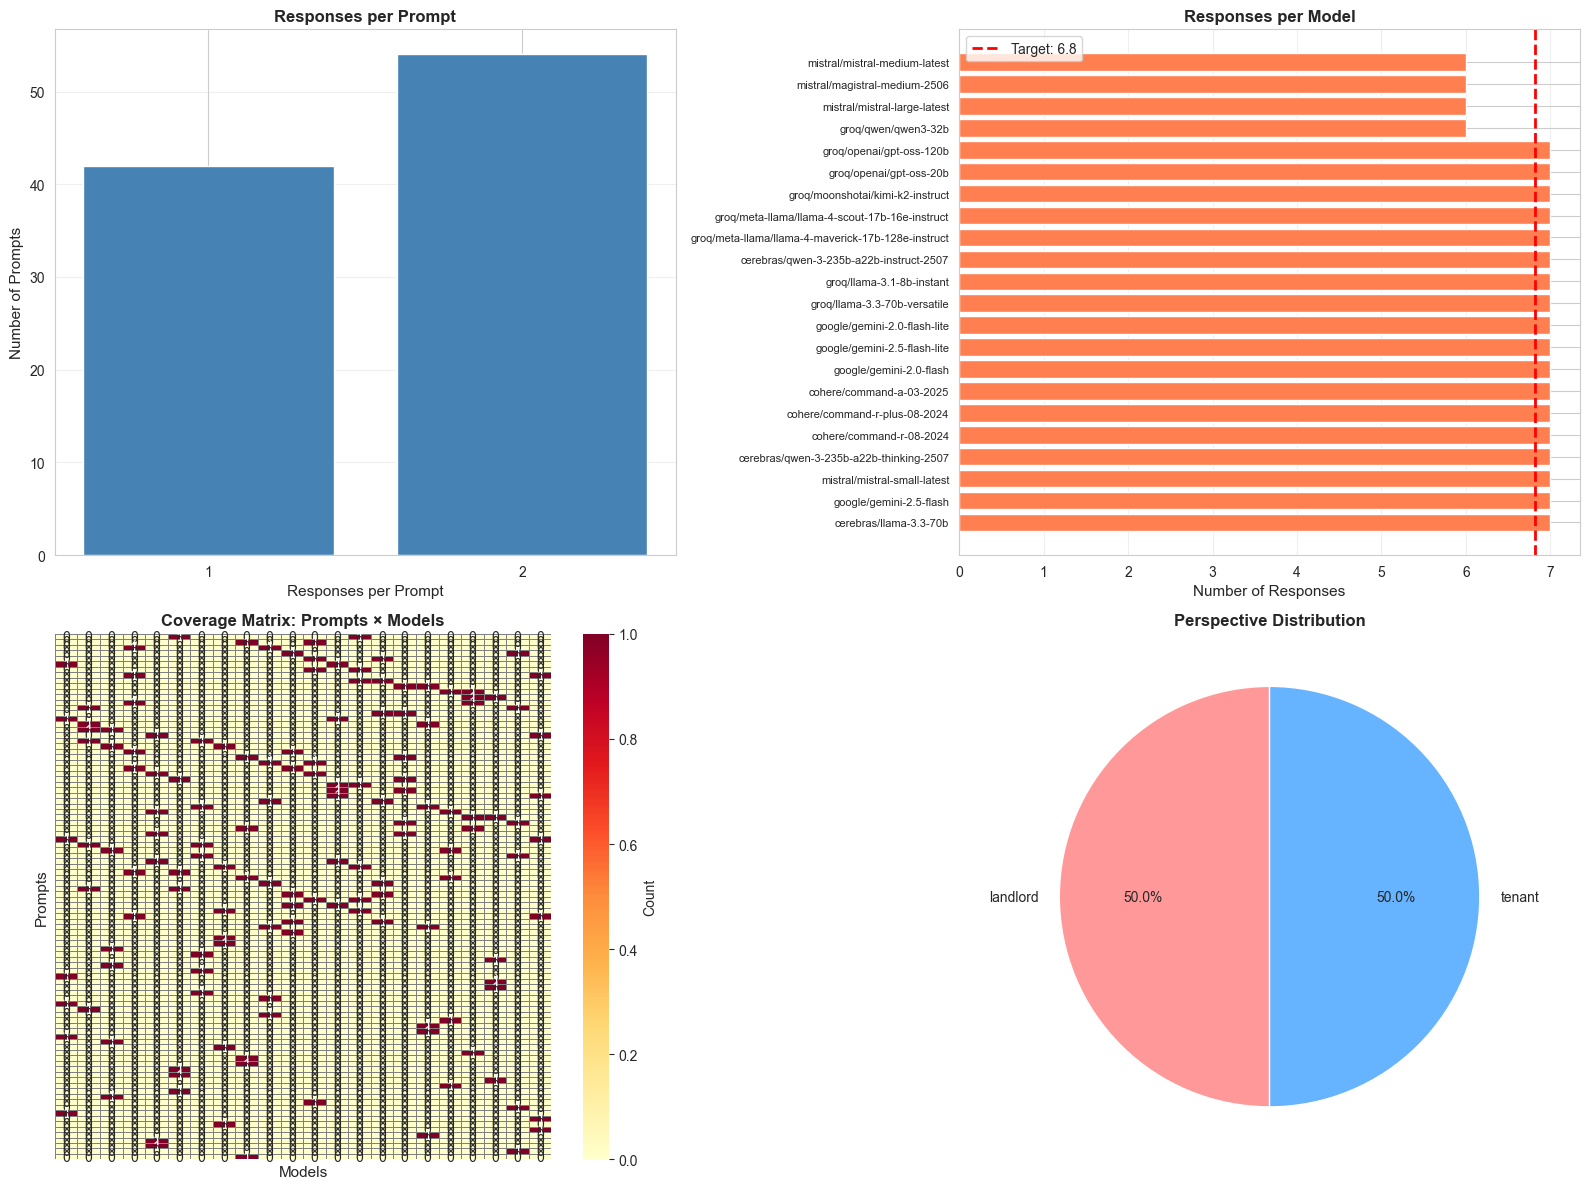

In [288]:
# Comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prompt distribution
prompt_dist = df_selected['prompt_id'].value_counts()
count_dist = prompt_dist.value_counts().sort_index()
axes[0, 0].bar(count_dist.index.astype(str), count_dist.values, color='steelblue')
axes[0, 0].set_title("Responses per Prompt", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Responses per Prompt", fontsize=11)
axes[0, 0].set_ylabel("Number of Prompts", fontsize=11)
axes[0, 0].grid(axis='y', alpha=0.3)

# Model distribution
model_dist = df_selected['model_id'].value_counts().sort_values(ascending=False)
axes[0, 1].barh(range(len(model_dist)), model_dist.values, color='coral')
axes[0, 1].set_yticks(range(len(model_dist)))
axes[0, 1].set_yticklabels(model_dist.index, fontsize=8)
axes[0, 1].axvline(target_per_model, color='red', linestyle='--', linewidth=2, label=f'Target: {target_per_model:.1f}')
axes[0, 1].set_title("Responses per Model", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Number of Responses", fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Coverage heatmap
coverage = df_selected.groupby(['prompt_id', 'model_id']).size().unstack(fill_value=0)
if len(coverage) > 0 and len(coverage.columns) > 0:
    coverage_sorted = coverage.sort_index(axis=0).sort_index(axis=1)
    sns.heatmap(
        coverage_sorted,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        linecolor='gray',
        ax=axes[1, 0],
        xticklabels=False,
        yticklabels=False
    )
    axes[1, 0].set_title("Coverage Matrix: Prompts × Models", fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel("Models", fontsize=11)
    axes[1, 0].set_ylabel("Prompts", fontsize=11)
else:
    axes[1, 0].text(0.5, 0.5, 'No data', ha='center', va='center')
    axes[1, 0].set_title("Coverage Matrix", fontsize=12, fontweight='bold')

# Perspective distribution
if 'perspective' in df_selected.columns:
    perspective_dist = df_selected['perspective'].value_counts()
    axes[1, 1].pie(
        perspective_dist.values,
        labels=perspective_dist.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff']
    )
    axes[1, 1].set_title("Perspective Distribution", fontsize=12, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'No perspective data', ha='center', va='center')
    axes[1, 1].set_title("Perspective Distribution", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Additional Statistics


In [289]:
# Additional Statistics
prompt_dist = df_selected['prompt_id'].value_counts()
print(f"Prompt distribution:")
print(f"  1 response: {(prompt_dist == 1).sum()} prompts")
print(f"  2 responses: {(prompt_dist == 2).sum()} prompts")
print(f"  Total unique: {len(prompt_dist)}")

if 'perspective' in df_selected.columns:
    perspective_dist = df_selected['perspective'].value_counts()
    print(f"\nPerspective distribution:")
    for perspective, count in perspective_dist.items():
        print(f"  {perspective}: {count} ({count/len(df_selected)*100:.1f}%)")


Prompt distribution:
  1 response: 42 prompts
  2 responses: 54 prompts
  Total unique: 96

Perspective distribution:
  landlord: 75 (50.0%)
  tenant: 75 (50.0%)


## Generate Run File Format

Convert selected records to the labeling platform run format (compatible with --run-file CLI).


In [290]:
# Generate run file format for labeling platform
grid_map = {row.get('prompt_id'): row for _, row in df_grid.iterrows() if row.get('prompt_id')}

# Use unique run_id to prevent overwriting existing scenario data
unique_run_id = f"run_{RUN_HASH}_sampled"

run_records = []
for _, row in df_selected.iterrows():
    prompt_id = str(row['prompt_id'])
    model_id = str(row['model_id'])
    perspective = row.get('perspective', 'unknown')
    
    # Get messages from grid_map if available, otherwise from row
    if prompt_id in grid_map:
        messages = grid_map[prompt_id].get('messages', [])
    else:
        messages = row.get('messages', [])
    
    run_records.append({
        "prompt_id": prompt_id,
        "model_id": model_id,
        "response_text": str(row.get('response_text', '')),
        "perspective": perspective,
        "factors": row.get('factors'),
        "provider": row.get('provider'),
        "messages": messages,
        "run_id": unique_run_id,
    })

print(f"Generated {len(run_records)} run records")
print(f"Run ID: {unique_run_id}")


Generated 150 run records
Run ID: run_2fd32deccbc3905b_sampled


## Export Results


In [291]:
# Export to JSONL (for DB push)
jsonl_path = run_dir / 'sampled_run.jsonl'
with jsonl_path.open('w', encoding='utf-8') as f:
    for record in run_records:
        f.write(json.dumps(record, ensure_ascii=False) + '\n')

print(f"Exported JSONL to: {jsonl_path}")
print(f"  Records: {len(run_records)}")
print(f"  Run ID: {unique_run_id}")

# Export to CSV (for inspection)
csv_records = []
for record in run_records:
    csv_record = {
        'prompt_id': record['prompt_id'],
        'model_id': record['model_id'],
        'perspective': record.get('perspective', ''),
        'provider': record.get('provider', ''),
        'run_id': record['run_id'],
        'response_text': record['response_text'][:200] + '...' if len(record['response_text']) > 200 else record['response_text'],
    }
    csv_records.append(csv_record)

df_csv = pd.DataFrame(csv_records)
csv_path = run_dir / 'sampled_run.csv'
df_csv.to_csv(csv_path, index=False)

print(f"Exported CSV to: {csv_path}")
print(f"  Records: {len(csv_records)}")

# Summary
print("\n" + "=" * 80)
print("EXPORT SUMMARY")
print("=" * 80)
print(f"JSONL file: {jsonl_path}")
print(f"CSV file: {csv_path}")
print(f"Total records: {len(run_records)}")
print(f"Run ID: {unique_run_id}")
print(f"\nTo push to database, run:")
print(f"  poetry run python scripts/data_portal.py push --dataset scenario --run-file {jsonl_path} --apply")
print(f"\nNote: Using unique run_id '{unique_run_id}' ensures data is added without overwriting existing scenario records.")


Exported JSONL to: run_2fd32deccbc3905b/sampled_run.jsonl
  Records: 150
  Run ID: run_2fd32deccbc3905b_sampled
Exported CSV to: run_2fd32deccbc3905b/sampled_run.csv
  Records: 150

EXPORT SUMMARY
JSONL file: run_2fd32deccbc3905b/sampled_run.jsonl
CSV file: run_2fd32deccbc3905b/sampled_run.csv
Total records: 150
Run ID: run_2fd32deccbc3905b_sampled

To push to database, run:
  poetry run python scripts/data_portal.py push --dataset scenario --run-file run_2fd32deccbc3905b/sampled_run.jsonl --apply

Note: Using unique run_id 'run_2fd32deccbc3905b_sampled' ensures data is added without overwriting existing scenario records.
